In [1]:
%cd "StressDetector-EEG-v2/"

/workspaces/Project_StressDetection/StressDetector-EEG-v2


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
import torch
from src.utils.transforms import DeapAVToStress

from torcheeg.datasets.constants.emotion_recognition.deap import \
    DEAP_CHANNEL_LOCATION_DICT

dataset = DEAPDataset(
    io_path=f'../data_cache/deap',
    root_path='../DEAP/data_preprocessed_python-002/data_preprocessed_python',
    online_transform=transforms.Compose([
        transforms.To2d(),
        transforms.ToTensor()
    ]),
    label_transform=transforms.Compose([
        transforms.Select(['arousal','valence']),
        # transforms.Binary(5.0),
        # transforms.BinariesToCategory(),
        DeapAVToStress(thresholds=[
            [7.5, 2.5],
            [5.0, 5.0]]),
    ]),
    num_worker=8)

[2024-01-29 05:52:17] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../data_cache/deap.


In [3]:
train_val_test_split = [0.6, 0.2, 0.2]

train_size = int(train_val_test_split[0] * len(dataset))
val_size = int(train_val_test_split[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [4]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

In [19]:
from torch.optim import SGD, Adam
from mmengine.runner import Runner
from src.models.eegnex import MMEEGNeX
from src.utils.metrics import AccuracyWithLoss, Accuracy, ConfusionMatrix


runner = Runner(
    # the model used for training and validation.
    # Needs to meet specific interface requirements

    model=MMEEGNeX(
        chunk_size=128,
        num_electrodes=32,
        dropout=0.5,
        F1=[8,32],
        F2=[16,8],
        D=2,
        num_classes=3,
        kernel_1=64,
        kernel_2=16
    ).float(),

    # working directory which saves training logs and weight files
    work_dir='./.exp/new_deap_stress/eegnex',
    
    # train dataloader needs to meet the PyTorch data loader protocol
    train_dataloader=train_loader,
    # optimize wrapper for optimization with additional features like
    # AMP, gradtient accumulation, etc
    optim_wrapper=dict(optimizer=dict(type=Adam, 
                                      lr=0.001,
                                      betas=(0.9, 0.999),
                                      eps=1e-08)),
    # trainging coinfs for specifying training epoches, verification intervals, etc
    train_cfg=dict(by_epoch=True, 
                   max_epochs=200, 
                   val_interval=1),
    
    # validation dataloader also needs to meet the PyTorch data loader protocol
    val_dataloader=val_loader,
    # validation configs for specifying additional parameters required for validation
    val_cfg=dict(),
    # validation evaluator. The default one is used here
    val_evaluator=dict(type=AccuracyWithLoss),

    # test dataloader also needs to meet the PyTorch data loader protocol
    test_dataloader=test_loader,
    # test configs for specifying additional parameters required for testing
    test_cfg=dict(),
    # test evaluator. The default one is used here
    test_evaluator=[dict(type=Accuracy), dict(type=ConfusionMatrix, num_classes=3)],

    visualizer=dict(type='Visualizer', vis_backends=[dict(type='TensorboardVisBackend')]),
    
    resume=True,
)

01/29 07:08:41 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 316967648
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.1.2+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gen

In [6]:
runner.train()

01/29 05:52:19 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in visualizer will be None.
01/29 05:52:19 - mmengine - WARNING - The prefix is not set in metric class AccuracyWithLoss.
01/29 05:52:19 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
01/29 05:52:19 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
01/29 05:52:19 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
01/29 05:52:19 - mmengine - INFO - Checkpoints will be saved to /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnex.
01/29 05:52:20 - mmengine - INFO - Epoch(train)   [1][ 10/720]  lr: 1.0000e-03  eta: 3:23:16  time: 0.0847  data_time: 0.0104  memory: 368  loss: 1.0432


2024-01-29 05:52:20.840247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 05:52:21.145429: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 05:52:21.167296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-

01/29 05:52:22 - mmengine - INFO - Epoch(train)   [1][ 20/720]  lr: 1.0000e-03  eta: 5:32:41  time: 0.1926  data_time: 0.1695  memory: 367  loss: 0.9169
01/29 05:52:22 - mmengine - INFO - Epoch(train)   [1][ 30/720]  lr: 1.0000e-03  eta: 3:59:53  time: 0.0226  data_time: 0.0006  memory: 367  loss: 0.8413
01/29 05:52:23 - mmengine - INFO - Epoch(train)   [1][ 40/720]  lr: 1.0000e-03  eta: 3:13:14  time: 0.0222  data_time: 0.0006  memory: 367  loss: 0.8144
01/29 05:52:23 - mmengine - INFO - Epoch(train)   [1][ 50/720]  lr: 1.0000e-03  eta: 2:45:23  time: 0.0225  data_time: 0.0008  memory: 367  loss: 0.8035
01/29 05:52:23 - mmengine - INFO - Epoch(train)   [1][ 60/720]  lr: 1.0000e-03  eta: 2:26:59  time: 0.0229  data_time: 0.0007  memory: 367  loss: 0.7672
01/29 05:52:23 - mmengine - INFO - Epoch(train)   [1][ 70/720]  lr: 1.0000e-03  eta: 2:13:45  time: 0.0227  data_time: 0.0006  memory: 367  loss: 0.7995
01/29 05:52:24 - mmengine - INFO - Epoch(train)   [1][ 80/720]  lr: 1.0000e-03  et

MMEEGNeX(
  (data_preprocessor): BaseDataPreprocessor()
  (eegnex): EEGNeX(
    (block1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Conv2d(8, 32, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (5): Conv2dWithConstraint(32, 64, kernel_size=(32, 1), stride=(1, 1), padding=same, groups=32, bias=False)
      (6): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (7): ELU(alpha=1.0)
      (8): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (9): Dropout(p=0.5, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, dilation=(1, 2), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentu

In [7]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


In [20]:
# Run trained model on test set
test_results = runner.test()

01/29 07:08:47 - mmengine - WARNING - The prefix is not set in metric class Accuracy.
01/29 07:08:47 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
01/29 07:08:48 - mmengine - INFO - Auto resumed from the latest checkpoint /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnex/epoch_200.pth.
Loads checkpoint by local backend from path: /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnex/epoch_200.pth
01/29 07:08:48 - mmengine - INFO - Load checkpoint from /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnex/epoch_200.pth
01/29 07:08:48 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in visualizer will be None.
01/29 07:08:48 - mmengine - WARNING - `resume_param_scheduler` is True but `self.param_schedulers` is None, so skip resuming parameter schedulers
01/29 07:08:48 - mmengine - INFO - resu

In [21]:
test_results

{'accuracy': tensor(77.5977),
 'confusion_matrix/result': tensor([[11706,   144,     0],
         [ 2872,   213,     0],
         [  398,    27,     0]])}

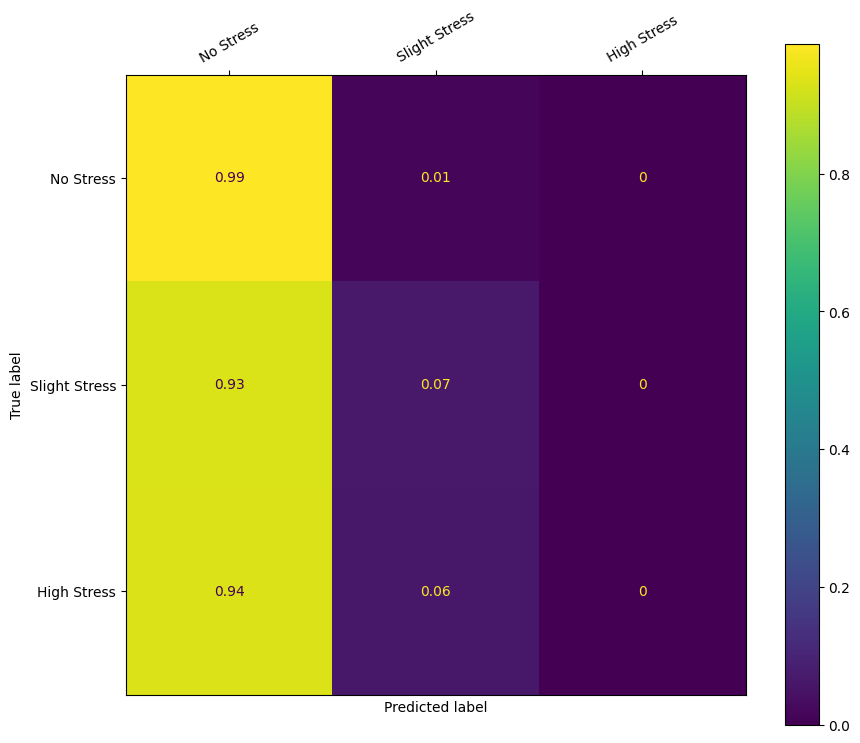

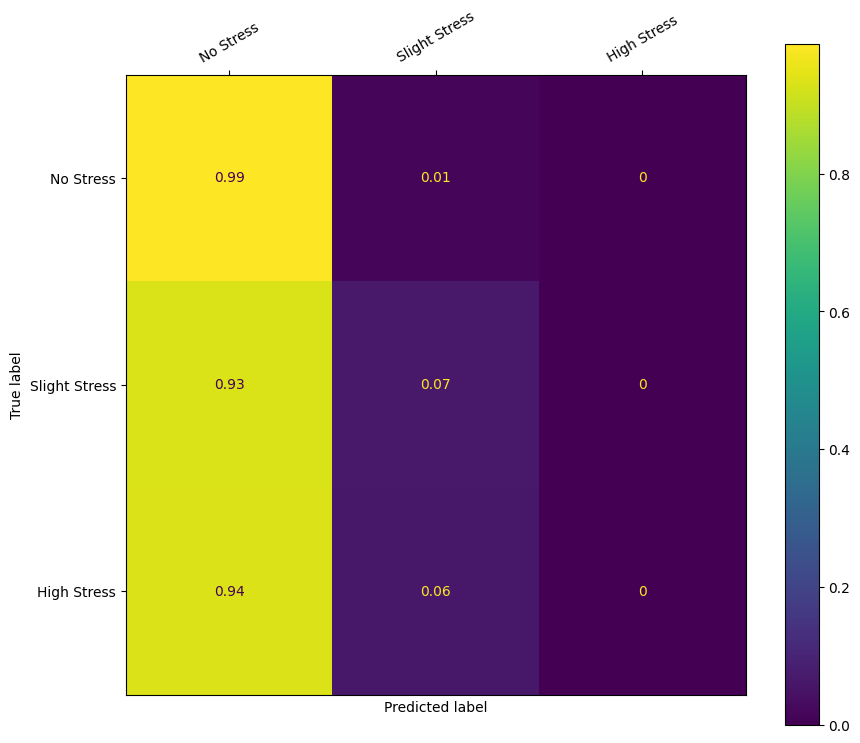

In [22]:
ConfusionMatrix().plot(test_results['confusion_matrix/result'], classes=['No Stress', 'Slight Stress', 'High Stress'], include_values=True, normalize=True)